# Five-dimensional Model of Heat Transfer through a Dual-pane Window
This script produces a plot comparing the probability density function of the heat flux for a fifth dimension model using three methods: non-instrusive spectral projection with sparse and full quadrature, as well as Monte Carlo sampling. It also produces a separate plot showing the spectral decay of the PC coefficients magnitude in relation to the PC order.

In [1]:
#general imports

from __future__ import print_function

try:
    import numpy as np
except ImportError:
    print("Numpy module could not be found")

try:
    import matplotlib.pyplot as plt
    from matplotlib import rc
    rc('mathtext', default='regular')
except ImportError:
    print("Matplotlib not found")

try:
    from scipy import stats
except ImportError:
    print("Scipy stats module could not be found")

try:
    import PyUQTk.pce as uqtkpce
except ImportError:
    print("PyUQTk PCE module not found")
    
try:
    import PyUQTk.PyPCE.pce_tools as pce_tools
except ImportError:
    print("PyUQTk pce_tools module not found")    

PyMC is required for some of the MCMC postprocessing codes.
Will proceed without, but some convergence tests will not be available.


In [2]:
#problem-specific imports

try:
    from fwd_prop_tools import *
except ImportError:
    print("File with PCE utilities not found.")

## Setting input arguments

In [3]:
main_verbose = 0 #set to 1 for intermediate print statements, otherwise set to 0
nord = 4 # Order of the PCE
ndim = 5 # Number of dimensions of the PCE
pc_type = "HG" #Polynomial type
pc_alpha = 0.0 #Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
pc_beta = 1.0 #Free parameter > -1 for Gamma-Laguerre and Beta-Jacobi PCs
param = nord +1 #quad points per dimension for full quadrature or level for sparse quadrature
n_MC = 100000 #number of random smaples of MC sampling

In [4]:
# The uncertain, Gaussian parameters used to calculate the heat flux

Ts = 200.0 # Sky temperature (K) #new
hi = 2.0   # Coefficient of convection inside (W/m^2*s)
ho = 6.0   # Coefficient of convection outside (W/m^2*s)
kw = 1.0   # Conduction constant for glass (W/m*K)
ka = 0.024 # Conduction constant for air (W/m*K)

# Set standard deviations of these uncertain parameters
std_Ts=Ts*0.1
std_hi=hi*0.15
std_ho=ho*0.15
std_kw=kw*0.05
std_ka=ka*0.05

## Forward propagation using Monte Carlo sampling

In [5]:
# Generate random samples of the uncertain parameters
samp_Ts=np.random.normal(Ts, std_Ts, n_MC)
samp_hi=np.random.normal(hi, std_hi, n_MC)
samp_ho=np.random.normal(ho, std_ho, n_MC)
samp_kw=np.random.normal(kw, std_kw, n_MC)
samp_ka=np.random.normal(ka, std_ka, n_MC)

# Create list of sample arrays
samples=[samp_Ts,samp_hi,samp_ho,samp_kw,samp_ka]

# List to store values of Q
Q_r_samples=[]

# Calculate values of heat flux Q assuming radiative heat transfer to atmosphere and append to list
# For the required estimates of Q,T1,T2,T3 and T4 needed to solve the nonlinear system,
# we use the values obtained by solving the system assuming no radiative heat transfer
for i in range(n_MC):
    (Q,T1,T2,T3,T4)=compute_heat_flux(samp_hi[i],samp_ho[i],samp_kw[i],samp_ka[i])
    Q2=r_heat_flux(samp_Ts[i],samp_hi[i],samp_ho[i],samp_kw[i],samp_ka[i],(Q,T1,T2,T3,T4))
    Q_r_samples.append(Q2)   
    
# Convert Q_r_samples into numpy array
Q_r_samples=np.array(Q_r_samples)

# Perform KDE on Q_r_samples
xpts_Q2, PDF_data_Q2= pce_tools.UQTkKDE(Q_r_samples)

## Forward propagation using PCEs and full quadrature

In [6]:
# Instantiate PC Object with full quadrature methods
pc_model = uqtkpce.PCSet("NISPnoq", nord,ndim,pc_type, pc_alpha,pc_beta)
pc_model.SetQuadRule(pc_type, 'full', param)
npce = pc_model.GetNumberPCTerms() # Number of terms in the PCE

if main_verbose > 0:
    print("The number of terms in each PCE is",npce)
    print("Multi-index and norm squared for all terms:")
    pc_model.PrintMultiIndexNormSquared()
    
#Get NumPy array of quadrature points, qdpts
#totquat is the total number of quad points
qdpts, totquat= pce_tools.UQTkGetQuadPoints(pc_model)

# Convert Quadrature points in ξ_i to equivalent samples of input parameters
# Taking advantage of the fact that inputs are assumed to be Gaussian
# Following parameter_samples = μ + σ(qdpts)
# This is equivalent to evaluating 1st order PC expansions for the input parameters.
Ts_samples = Ts + std_Ts * qdpts[:,0]
hi_samples = hi + std_hi * qdpts[:,1]
ho_samples = ho + std_ho * qdpts[:,2]
kw_samples = kw + std_kw * qdpts[:,3]
ka_samples = ka + std_ka * qdpts[:,4]

# Evaluate Forward model for sampled parameters, computing the heat flux Q
# Q_evals is an array of evaluations of the forward model
Q_evals=fwd_model(Ts_samples,hi_samples,ho_samples,kw_samples,ka_samples,)

# Galerkin Projection to obtain PC coefficients
c_k = pce_tools.UQTkGalerkinProjection(pc_model,Q_evals)

# Generate germ samples
germ_samples=np.random.normal(0,1, (n_MC,ndim))

# Evaluate the PCE at the germ samples
pce_evals=pce_tools.UQTkEvaluatePCE(pc_model,c_k,germ_samples)

#Peform kernel density estimation
xpts_pce, PDF_data_pce = pce_tools.UQTkKDE(pce_evals)

nqp 3125
function eval array 3125


## Forward Propagation with sparse quadrature

In [7]:
# Instantiate PC Object with sparse quadrature methods
pc_model2 = uqtkpce.PCSet("NISPnoq", nord,ndim,pc_type, pc_alpha,pc_beta)
pc_model2.SetQuadRule(pc_type, 'sparse', param)
npce2 = pc_model2.GetNumberPCTerms() # Number of terms in the PCE

if main_verbose > 0:
    print("The number of terms in each PCE is",npce2)
    print("Multi-index and norm squared for all terms:")
    pc_model2.PrintMultiIndexNormSquared()
    
#Get NumPy array of quadrature points, qdpts
#totquat2 is the number of quad points
qdpts2, totquat2= pce_tools.UQTkGetQuadPoints(pc_model2)

# Convert Quadrature points in ξ_i to equivalent samples of input parameters
# Taking advantage of the fact that inputs are assumed to be Gaussian
# Following parameter_samples = μ + σ(qdpts)
# This is equivalent to evaluating 1st order PC expansions for the input para
Ts_samples2 = Ts + std_Ts * qdpts2[:,0]
hi_samples2 = hi + std_hi * qdpts2[:,1]
ho_samples2 = ho + std_ho * qdpts2[:,2]
kw_samples2 = kw + std_kw * qdpts2[:,3]
ka_samples2 = ka + std_ka * qdpts2[:,4]

# Evaluate Forward model for sampled parameters, computing the heat flux Q
# Q_evals2 is an array of evaluations of the forward model
Q_evals2=fwd_model(Ts_samples2,hi_samples2,ho_samples2,kw_samples2,ka_samples2,)

# Galerkin Projection to obtain PC coefficients
c_k2 = pce_tools.UQTkGalerkinProjection(pc_model2,Q_evals2)

# Generate germ samples
germ_samples2=np.random.normal(0,1, (n_MC,ndim))

# Evaluate the PCE at the germ samples
pce_evals2=pce_tools.UQTkEvaluatePCE(pc_model2,c_k2,germ_samples2)

#Peform kernel density estimation
xpts_pce2, PDF_data_pce2= pce_tools.UQTkKDE(pce_evals2)

KUKU 0 1
KUKU 0 5
KUKU 1 5
KUKU 2 5
KUKU 3 5
KUKU 4 5
KUKU 0 15
KUKU 1 15
KUKU 2 15
KUKU 3 15
KUKU 4 15
KUKU 5 15
KUKU 6 15
KUKU 7 15
KUKU 8 15
KUKU 9 15
KUKU 10 15
KUKU 11 15
KUKU 12 15
KUKU 13 15
KUKU 14 15
KUKU 0 35
KUKU 1 35
KUKU 2 35
KUKU 3 35
KUKU 4 35
KUKU 5 35
KUKU 6 35
KUKU 7 35
KUKU 8 35
KUKU 9 35
KUKU 10 35
KUKU 11 35
KUKU 12 35
KUKU 13 35
KUKU 14 35
KUKU 15 35
KUKU 16 35
KUKU 17 35
KUKU 18 35
KUKU 19 35
KUKU 20 35
KUKU 21 35
KUKU 22 35
KUKU 23 35
KUKU 24 35
KUKU 25 35
KUKU 26 35
KUKU 27 35
KUKU 28 35
KUKU 29 35
KUKU 30 35
KUKU 31 35
KUKU 32 35
KUKU 33 35
KUKU 34 35
KUKU 0 70
KUKU 1 70
KUKU 2 70
KUKU 3 70
KUKU 4 70
KUKU 5 70
KUKU 6 70
KUKU 7 70
KUKU 8 70
KUKU 9 70
KUKU 10 70
KUKU 11 70
KUKU 12 70
KUKU 13 70
KUKU 14 70
KUKU 15 70
KUKU 16 70
KUKU 17 70
KUKU 18 70
KUKU 19 70
KUKU 20 70
KUKU 21 70
KUKU 22 70
KUKU 23 70
KUKU 24 70
KUKU 25 70
KUKU 26 70
KUKU 27 70
KUKU 28 70
KUKU 29 70
KUKU 30 70
KUKU 31 70
KUKU 32 70
KUKU 33 70
KUKU 34 70
KUKU 35 70
KUKU 36 70
KUKU 37 70
KUKU 38 

In [8]:
len(c_k)

126

## Summary information


Monte Carlo sampling used 100000 points
Full quadrature method used 3125 points
Sparse quadrature method used 10363 points
1   -9.462299674415961

Multi_Index_Dim.pdf has been saved.


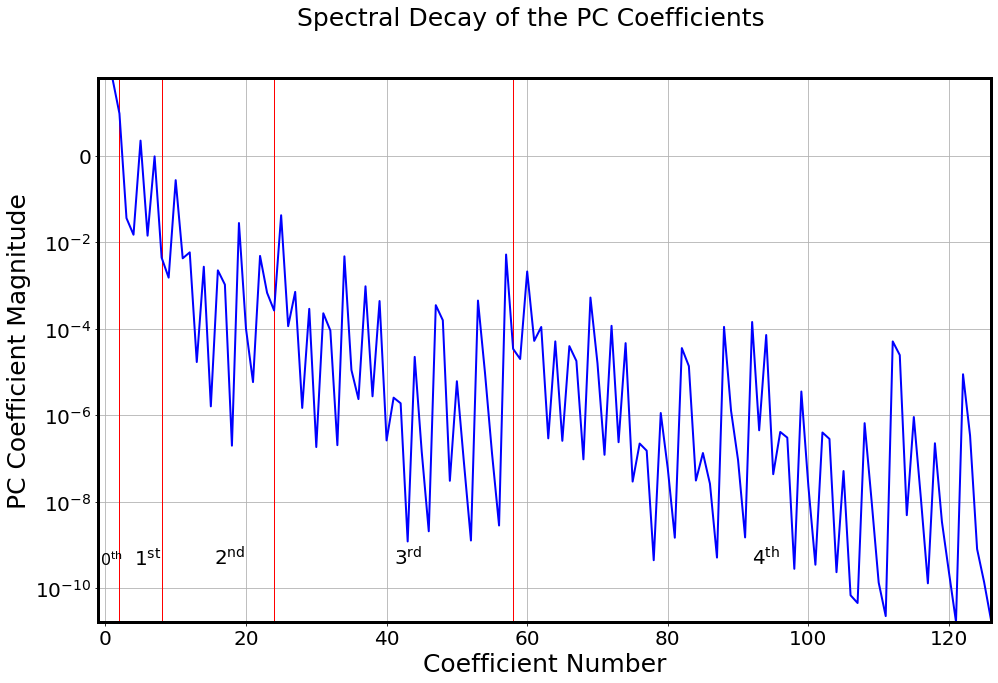


fd_heat_flux_pce.pdf has been saved.


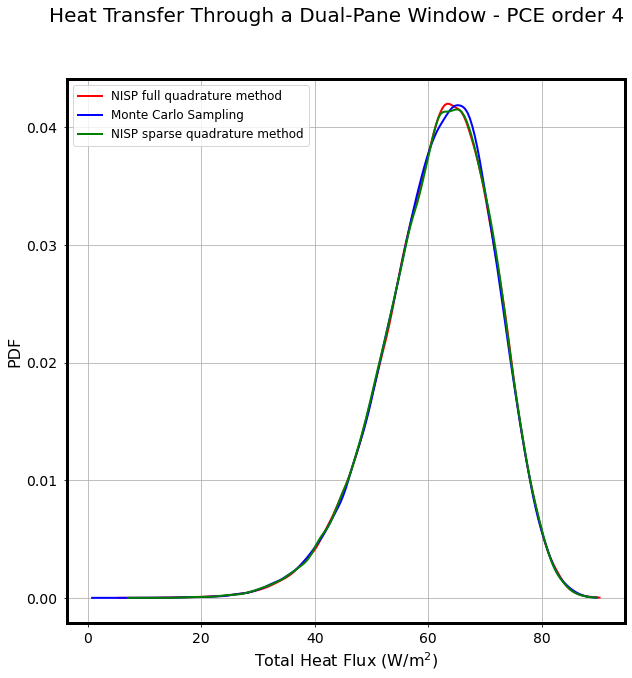

In [9]:
# Print statements to indicate number of samples used
print("\nMonte Carlo sampling used %s points" %(n_MC))
print("Full quadrature method used %s points" %(totquat))
print("Sparse quadrature method used %s points" %(totquat2))

#Plot showing the spectral decay of the PC coefficient magnitude in relation PC order. 
#Illustrates how projection converges to a precise representation of the model.
#Changing nord may alter the results of the second plot, since it has elements that are not dynamically linked
pce_tools.UQTkPlotMiDims(pc_model,c_k,ndim)

# Plot the three PDF curves on the same figure
plt.figure(figsize=(10,10))
plt.plot(xpts_pce, PDF_data_pce, linewidth=2, color='r', label='NISP full quadrature method')
plt.plot(xpts_Q2, PDF_data_Q2, linewidth=2, color='b', label='Monte Carlo Sampling')
plt.plot(xpts_pce2, PDF_data_pce2, linewidth=2, color='g', label= 'NISP sparse quadrature method')

# Label Axes
plt.xlabel(r'Total Heat Flux ($W/m^2$)', size=16)
plt.ylabel("PDF", size=16)
# Add title
plt.suptitle("Heat Transfer Through a Dual-Pane Window - PCE order %s"%(nord), size=20)
# Change tick size
plt.tick_params(axis='both', labelsize=14)
# Pad tick labels
plt.gca().tick_params(pad=6)
# Create legend
plt.legend(loc='upper left', prop={'size':12})
# Save figure
fig_name="fd_heat_flux_pce.pdf"
plt.savefig(fig_name)
print("\nfd_heat_flux_pce.pdf has been saved.")
# Show figure
plt.show()